In [19]:
# import library
import matplotlib.pyplot as plt
import random
import numpy as np

# 1. 초기 population 생성
def make_init_population(distance_matrix):
    city_num = len(distance_matrix[0])
    city_list = list(range(city_num)) #도시 수 만큼 리스트 생성 0-n
    population = [] # 초기 population

    # 초기 population 만드는 과정
    for _ in range(100):
        temp_list = city_list.copy()
        random.shuffle(temp_list)
        population.append(temp_list)
    return population

# 2. build GA
# 2-0. fitness 함수
def fitness(matrix, chromosome):
    # 거리가 가까운 것이 좋으니 1/거리로 적합도 함수 생성
    distance = 0
    for i in chromosome:
        try:
            distance += matrix[chromosome[i]][chromosome[i+1]]
        except IndexError: # try문은 맨 마지막이 index에러나서 맨 마지막 인덱스와 첫 인덱스 간의 거리를 구하는 코드
            distance += matrix[chromosome[i]][chromosome[0]]
    return 1/distance

# 2-0. population에 대한 fitness 함수
def population_fit(matrix, population):
    population_fitness = []
    f=0
    for i in range(len(population)):
        f = fitness(matrix, population[i])
        population_fitness.append(f)
    return population_fitness

# 2-0. 거리 구하는 함수
def distance(matrix, chromosome):
    # 거리가 가까운 것이 좋으니 1/거리로 적합도 함수 생성
    distance = 0
    for i in chromosome:
        try:
            distance += matrix[chromosome[i]][chromosome[i+1]]
        except IndexError: # try문은 맨 마지막이 index에러나서 맨 마지막 인덱스와 첫 인덱스 간의 거리를 구하는 코드
            distance += matrix[chromosome[i]][chromosome[0]]
    return distance

# 2-0. population에 대한 거리 구하는 함수
def population_distance(matrix, population):
    population_distance = []
    d=0
    for i in range(len(population)):
        d = distance(matrix, population[i])
        population_distance.append(d)
    return population_distance

# 2-1. 셀렉션 - 룰렛휠 셀렉션

def Selection(distance_matrix, population):
    fitness_list = population_fit(distance_matrix, population)
    total_fitness = sum(fitness_list) # 적합도의 합계 계산
    selection_probs = [f/total_fitness for f in fitness_list]  # 선택 확률 계산
    # 2개 뽑기
    pick = np.random.choice(len(fitness_list), size=2, p=selection_probs, replace=False)
    
    # 반환
    return pick

# 2-2. 크로스오버 - order 크로스오버
def Crossover(parent1, parent2):
    cut_points = sorted(random.sample(range(len(parent1)), 2))
    length = len(parent1)
    child = [-1] * length #child 리스트를 초기화, 모든 요소를 -1로 설정
    
    # parent1에서 값을 복사
    for i in range(cut_points[0], cut_points[1]):
        child[i] = parent1[i]
    
    # parent2에서 값을 복사
    # child에 이미 있는 값은 제외, parent2의 값 순서대로 채움
    p2_index = 0
    for i in list(range(cut_points[1], length)) + list(range(0, cut_points[1])):
        if child[i] == -1:
            while parent2[p2_index] in child:
                p2_index += 1
            child[i] = parent2[p2_index]
            p2_index += 1
    #print(cut_points)
    return child

# 2-3. Mutation - swap Mutation
def Mutation(offspring, iteration):
    mutation_probs = random.randint(0, 1000)/1000.0 # 입력한 offspring의 mutation 확률
    mutation_rate = 0 # mutatation rate
    # iteration이 커지면 mutation rate가 줄어들게 설계
    if(iteration < 2000):
        mutation_rate = 0.3
    elif(iteration < 10000):
        mutation_rate = 0.2
    else:
        mutation_rate = 0.1
    #mutation 실행
    if(mutation_probs < mutation_rate):
        mutation_point = random.sample(range(len(offspring)), 2)
        offspring[mutation_point[0]], offspring[mutation_point[1]] = offspring[mutation_point[1]], offspring[mutation_point[0]]
        
    return offspring #반환

# 2-4. local optimization - 3-OPT
from random import random

def three_opt(path, distance_matrix):
    best_path = path[:]
    best_fitness = fitness(distance_matrix, best_path)
    improvement = True
    while improvement:  # 개선된 경로를 찾는 동안 반복
        improvement = False
        for i in range(len(path)-2):
            for j in range(i+1, len(path)-1):
                for k in range(j+1, len(path)):
                    # 첫 번째 방법: i, j 사이의 경로 바꾸기
                    new_path1 = path[:i] + \
                        path[i:j][::-1] + path[j:k] + path[k:]
                    # 두 번째 방법: j, k 사이의 경로 바꾸기
                    new_path2 = path[:i] + path[i:j] + \
                        path[j:k][::-1] + path[k:]
                    # 세 번째 방법: i, j와 j, k 사이의 경로 부분을 뒤집기
                    new_path3 = path[:i] + path[j:k] + path[i:j] + path[k:]

                    new_fitness1 = fitness(distance_matrix, new_path1)
                    new_fitness2 = fitness(distance_matrix, new_path2)
                    new_fitness3 = fitness(distance_matrix, new_path3)

                    # 적합도 비교 및 업데이트
                    if new_fitness1 > best_fitness:
                        best_path = new_path1[:]
                        best_fitness = new_fitness1
                        improvement = True

                    if new_fitness2 > best_fitness:
                        best_path = new_path2[:]
                        best_fitness = new_fitness2
                        improvement = True

                    if new_fitness3 > best_fitness:
                        best_path = new_path3[:]
                        best_fitness = new_fitness3
                        improvement = True
        path = best_path[:]
    return best_path

# 2-4. local optimization - lk-algoritm
# lock이후 뒤집기
def reverse_path_from_city(path, city):
    city_index = path.index(city)
    return path[:city_index + 1] + path[city_index + 1:][::-1]

# 가까운 도시 찾기
def find_closest_city(last_city, distance_matrix, lock_list):
    min_distance = float('inf')
    closest_city = None
    for i, distance in enumerate(distance_matrix[last_city]):
        if i not in lock_list and distance < min_distance:
            min_distance = distance
            closest_city = i
    return closest_city

# lk 실행
def lk_algorithm(path, distance_matrix):
    lock_list = [path[0]]
    path_list=[]
    while len(lock_list) < len(path):
        # 끝 인덱스 도시와 가장 가까운 도시 찾기
        closest_city = find_closest_city(path[-1], distance_matrix, lock_list)
        # lock_list에 넣기
        lock_list.append(closest_city)
        # lock된 도시 이후 뒤집기
        path = reverse_path_from_city(path, closest_city)
        # path_list에 이 순서 저장
        path_list.append(path)
    # best_path를 반환하기 위한 코드
    path_distance_list = population_distance(distance_matrix, path_list)
    best_path_index = path_distance_list.index(min(path_distance_list))
    best_path = path_list[best_path_index]
    return best_path


# 2-5. Replace - steady-state GA

def Replace(offspring, population, distance_matrix):
    fitness_list = [] #적합도 리스트 생성
    f=0
    # population의 적합도를 모두 생성하고 집어넣음
    fitness_list = population_fit(distance_matrix, population)
    # 적합도가 worst한 리스트는 offspring과 대체
    worst_index = fitness_list.index(min(fitness_list))
    population[worst_index] = offspring
    
    return population #리턴



In [20]:
import random
# Load data
# 텍스트 데이터
text_data = """
         0        29        82        46        68        52        72        42        51        55        29        74        23        72        46
        29         0        55        46        42        43        43        23        23        31        41        51        11        52        21
        82        55         0        68        46        55        23        43        41        29        79        21        64        31        51
        46        46        68         0        82        15        72        31        62        42        21        51        51        43        64
        68        42        46        82         0        74        23        52        21        46        82        58        46        65        23
        52        43        55        15        74         0        61        23        55        31        33        37        51        29        59
        72        43        23        72        23        61         0        42        23        31        77        37        51        46        33
        42        23        43        31        52        23        42         0        33        15        37        33        33        31        37
        51        23        41        62        21        55        23        33         0        29        62        46        29        51        11
        55        31        29        42        46        31        31        15        29         0        51        21        41        23        37
        29        41        79        21        82        33        77        37        62        51         0        65        42        59        61
        74        51        21        51        58        37        37        33        46        21        65         0        61        11        55
        23        11        64        51        46        51        51        33        29        41        42        61         0        62        23
        72        52        31        43        65        29        46        31        51        23        59        11        62         0        59
        46        21        51        64        23        59        33        37        11        37        61        55        23        59         0
"""

# 줄별로 분할
lines = text_data.strip().split("\n")
# 2중 리스트 생성
distance_matrix = [list(map(int, line.split())) for line in lines]
iteration = 0
std_list=[]
best_index = 0
best_distance = []
distance_mean = []

# 초기 population 생성
population = make_init_population(distance_matrix) 
# 1회 실행
# 셀렉션
p = Selection(distance_matrix, population)
# 크로스오버
offspring = Crossover(population[p[0]], population[p[1]])
# 뮤테이션
offspring = Mutation(offspring, iteration)
# local-optimization
offspring = lk_algorithm(offspring, distance_matrix)
#offspring = three_opt(offspring, distance_matrix)
# replace
population = Replace(offspring, population, distance_matrix)
#기타
iteration += 1 # 반복횟수 표시를 위한 코드
distance_list = population_distance(distance_matrix, population) # 종료조건을 위한 코드
best_index = distance_list.index(min(distance_list))# 시각화를 위한 코드
best_distance.append(distance(distance_matrix, population[best_index]))# 시각화를 위한 코드
distance_mean.append(np.mean(distance_list))
std_list.append(np.std(distance_list))# 시각화를 위한 코드
print(iteration)# 반복횟수 출력
# 2회-종료조건까지 실행
while(np.std(distance_list)>0):
#while(iteration<5000):
        # 셀렉션
        p = Selection(distance_matrix, population)
        # 크로스오버
        offspring = Crossover(population[p[0]], population[p[1]])
        # 뮤테이션
        offspring = Mutation(offspring, iteration)
        # local-optimization
        offspring = lk_algorithm(offspring, distance_matrix)
        #offspring = three_opt(offspring, distance_matrix)
        # replace
        population = Replace(offspring, population, distance_matrix)
        #기타
        iteration += 1 # 반복횟수 표시를 위한 코드
        distance_list = population_distance(distance_matrix, population)# 종료조건을 위한 코드
        best_index = distance_list.index(min(distance_list))# 시각화를 위한 코드
        best_distance.append(distance(distance_matrix, population[best_index]))# 시각화를 위한 코드
        distance_mean.append(np.mean(distance_list))
        std_list.append(np.std(distance_list))# 시각화를 위한 코드
        print(iteration)

print(np.std(distance_list))



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [21]:
for i in range(100):
    print(i, ": ",population[i], "여행거리: ", distance(distance_matrix, population[i]))

0 :  [0, 10, 3, 5, 7, 9, 13, 11, 2, 6, 4, 8, 14, 1, 12] 여행거리:  291
1 :  [14, 1, 12, 0, 10, 3, 5, 7, 9, 13, 11, 2, 6, 4, 8] 여행거리:  291
2 :  [9, 7, 5, 3, 10, 0, 12, 1, 14, 8, 4, 6, 2, 11, 13] 여행거리:  291
3 :  [5, 7, 9, 13, 11, 2, 6, 4, 8, 14, 1, 12, 0, 10, 3] 여행거리:  291
4 :  [6, 4, 8, 14, 1, 12, 0, 10, 3, 5, 7, 9, 13, 11, 2] 여행거리:  291
5 :  [11, 2, 6, 4, 8, 14, 1, 12, 0, 10, 3, 5, 7, 9, 13] 여행거리:  291
6 :  [11, 13, 9, 7, 5, 3, 10, 0, 12, 1, 14, 8, 4, 6, 2] 여행거리:  291
7 :  [1, 12, 0, 10, 3, 5, 7, 9, 13, 11, 2, 6, 4, 8, 14] 여행거리:  291
8 :  [14, 1, 12, 0, 10, 3, 5, 7, 9, 13, 11, 2, 6, 4, 8] 여행거리:  291
9 :  [2, 11, 13, 9, 7, 5, 3, 10, 0, 12, 1, 14, 8, 4, 6] 여행거리:  291
10 :  [10, 3, 5, 7, 9, 13, 11, 2, 6, 4, 8, 14, 1, 12, 0] 여행거리:  291
11 :  [6, 4, 8, 14, 1, 12, 0, 10, 3, 5, 7, 9, 13, 11, 2] 여행거리:  291
12 :  [6, 4, 8, 14, 1, 12, 0, 10, 3, 5, 7, 9, 13, 11, 2] 여행거리:  291
13 :  [6, 4, 8, 14, 1, 12, 0, 10, 3, 5, 7, 9, 13, 11, 2] 여행거리:  291
14 :  [1, 12, 0, 10, 3, 5, 7, 9, 13, 11, 2, 6, 4, 8, 14] 여

In [22]:
best_index = distance_list.index(min(distance_list))
print("최소 경로: ", population[best_index], "최소여행거리: ",distance(distance_matrix, population[best_index]), "iteration: ", iteration)

최소 경로:  [0, 10, 3, 5, 7, 9, 13, 11, 2, 6, 4, 8, 14, 1, 12] 최소여행거리:  291 iteration:  1398


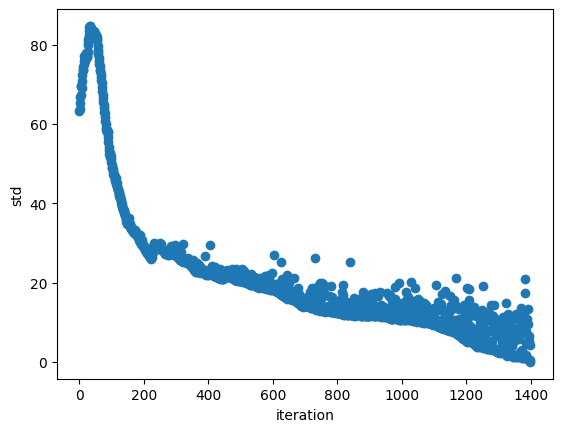

In [23]:
# 반복횟수:표준편차 시각화
import matplotlib.pyplot as plt
iteration_list = [i+1 for i in range(iteration)] # 0-최종 iteration값 저장
plt.scatter(iteration_list, std_list)
plt.xlabel('iteration')
plt.ylabel('std')
plt.show()

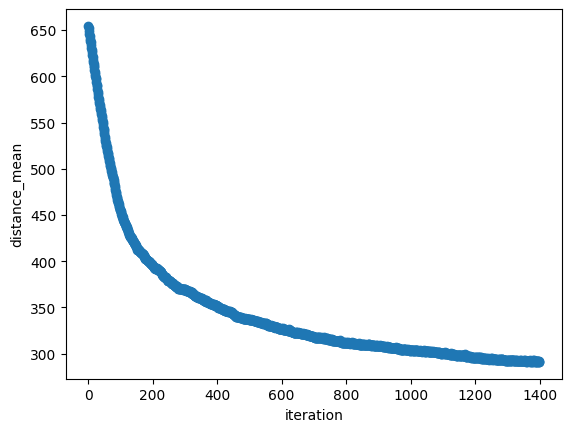

In [24]:
# 반복횟수:population 평균 거리 시각화
import matplotlib.pyplot as plt
plt.scatter(iteration_list, distance_mean)
plt.xlabel('iteration')
plt.ylabel('distance_mean')
plt.show()